# Case Study: distance estimation 

In this case study, we will estimate the .........

## 1. Import code 

In [120]:
# Import dependencies
import os
from cvzone.FaceMeshModule import FaceMeshDetector 
import cv2
from models.code.cvzone import detect_face_cvzone
import matplotlib.pyplot as pyplot

## 2. Distance estimation function

In [121]:
INTEROCULAR_DISTANCE = 6.3

# Focal length of the camera in use (in some unit)
focal_length = 655

# Face mesh detector configured to detect a maximum of one face
CVZONE_DETECTOR_MAX_ONE = FaceMeshDetector(maxFaces=1)

# Constants for CVZone face mesh indices for eye locations
EYE_DISTANCE_INDEX = {
    'left_eye': 145,
    'right_eye': 374
}

# Function for estimating distance 
def estimate_depth(landmarks: list[list[int]], focal_length):
    """Estimate the Z-coordinate (depth) for a detected face.

    This function calculates the depth, which is the distance between the screen and the user, using a method that relies on the distance between the eyes. 
    It uses the focal length and the average distance between the eyes, to estimate the depth based on eye landmarks detected. 

    Parameters:
        landmarks (list[list[int]]): A list of arrays, each array representing a landmark with x and y position of that landmark.

    Returns:
        int: The distance between the user and the camera 
    
    """
    # Check that the list has the 468 landmarks 
    if len(landmarks) != 468:
        print("ERROR: Invalid length of landmark list expected 468, was {len(landmarks)}")
        return None 
    
    # Retrieve the eye indexes 
    left_eye = landmarks[EYE_DISTANCE_INDEX['left_eye']]
    right_eye = landmarks[EYE_DISTANCE_INDEX['right_eye']]

    # Calculate distance between eyes
    w, _ = CVZONE_DETECTOR_MAX_ONE.findDistance(left_eye, right_eye)
    
    # Estimate depth
    return int((INTEROCULAR_DISTANCE * focal_length) / w)

I0000 00:00:1714572940.882412    6354 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1714572940.884804    9642 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: RENOIR (renoir, LLVM 15.0.7, DRM 3.54, 6.5.0-28-generic)


## 3. Dataset 

The dataset is created by us to check the distance estimation is correct. 
The images are labeled by a ground truth measured in inches. 

The following distances are in out custom dataset: 

- 20 inches
- 30 inches
- 40 inches
- 50 inches
- 60 inches
- 70 inches
- 80 inches

The range is from 20 inches (50.8 cm) to  80 inches (203.2 cm). This range covers the desired testing range as mentioned in the goals for this thesis. 

Run the code block below to verify that the dataset exists:

In [122]:
# Verify the data set 
dataset_dir = "./datasets/distance_dataset/"

# List of expected file names
files_to_check = [
    "20inches.jpg", "30inches.jpg", "40inches.jpg",
    "50inches.jpg", "60inches.jpg", "70inches.jpg",
    "80inches.jpg"
]

# Check if each file exists in the directory
for filename in files_to_check:
    file_path = os.path.join(dataset_dir, filename)
    assert os.path.exists(file_path), f"Was not able to find: {file_path}"

All the images has been labeled manually. For each distance, each x and y position of each eye are set. You can expect some reasonable error with this labeling, but the error rate should be relatively low. 

The labeled information can be found in the file: `./datasets/distance_dataset/eye_positions.txt`.

Run the following code block to setup the mock output for the CVZone face detection model. 
**Note:** The output is mocked due to the avoid that face detection model is also tested. This is not the purpose of **this** case study.

In [123]:
# Define the dictionary for eye distance index
EYE_DISTANCE_INDEX = {
    'left_eye': 145,
    'right_eye': 374
}

# Define the positions for each image
eye_positions = {
    20: {"left": [1180, 525], "right": [1340, 525]},
    30: {"left": [1198, 625], "right": [1320, 625]},
    40: {"left": [1183, 670], "right": [1270, 670]},
    50: {"left": [1298, 703], "right": [1369, 703]},
    60: {"left": [1295, 751], "right": [1359, 751]},
    70: {"left": [1354, 773], "right": [1403, 773]},
    80: {"left": [1322, 754], "right": [1366, 754]}
}

# Create the map of landmarks
# The key is how many inches the user is away from the camera
# The value is the mocked output from CVZone
landmark_map = {}

# Setting up the map based on the positions 
for inch, pos in eye_positions.items():
    # Create a list of 468 elements initialized with None
    landmarks = [[0, 0] for _ in range(468)]
    
    # Set the left and right eye positions
    landmarks[EYE_DISTANCE_INDEX['left_eye']] = pos['left']
    landmarks[EYE_DISTANCE_INDEX['right_eye']] = pos['right']
    
    # Store in the map
    landmark_map[inch] = landmarks
 

## 4. Calculate the focal length

Focal length can be calculated with the following equation: 

$$ \frac{1}{F} = \frac{1}{O} + \frac{1}{L} $$

Where: 
- F: Focal length of the camera
- O: distance between the lens and the object
- L: distance between the lens and the image 


The following function calculated the focal length based on this equation: 

In [124]:
# Function for the calculation for the focal length 
def calculate_focal_length(object_distance, image_distance):
    return 1 / ((1 / image_distance) + (1 / object_distance)) 


In [125]:
def preprocess_image(image_path):

    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Check if the image was loaded properly
    if image is None:
        raise ValueError("Image cannot be loaded. Please check the file path and ensure it is correct.")

    # Resize the image to make it smaller and increase processing speed
    image = cv2.resize(image, (1800, 1400))  # Adjust the size parameters as needed
    
    # Convert to grayscale for face detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(gray_image)
    
    # Reduce noise with a Gaussian filter to smooth out the image
    smoothed_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
    # Convert grayscale back to BGR for CVZone compatibility
    final_image = cv2.cvtColor(smoothed_image, cv2.COLOR_GRAY2BGR)
    
    return final_image

## 5. Testing the dataset based on estimated focal length 

To first calculate the focal length of the camera, we are going to use the first image in the dataset to calculate the focal length of the image.

Then we are going to check the error rate for based on that focal length: 



In [126]:
# Check the first image
path_to_image = dataset_dir + "20inches.jpg"
image = preprocess_image(path_to_image)


# Asserting that the image was read correctly 
assert image is not None, "ERROR: could not read image"

# Detecting the face in the image with the CVZone measurement 
face = detect_face_cvzone(image, CVZONE_DETECTOR_MAX_ONE, detect_multiple_faces=False)
assert len(face) == 468, "ERROR: could not detect the face in the image"

# Calculate the estimate depth 
depth = estimate_depth(face, focal_length)
print(f"[INFO] Estimated depth calculated is {depth} cm")

# 20 inches to cm => 50.8 cm
image_distance = 50.8 

# Calculate the focal length of the camera
ground_truth_focal_length = calculate_focal_length(object_distance=depth, image_distance=image_distance)
print(f"[INFO] Calculated focal length: {ground_truth_focal_length}")



[INFO] Estimated depth calculated is 33 cm
[INFO] Calculated focal length: 20.004773269689736


The focal length is suggested. To test it and to check if it the new focal length gives a better performance: 
### TODO: skrive denne bedre

In [138]:
import os

# Inches to cm converter function
def to_cm(inches):
    return inches * 2.54

def adjust_focal_length(detected_distance, actual_distance, current_focal_length, learning_rate=0.1):
    error = actual_distance - detected_distance
    adjustment = learning_rate * error  # Calculate the adjustment directly proportional to the error
    new_focal_length = current_focal_length + adjustment  # Update the focal length by adding the adjustment
    return new_focal_length


# Initial focal length
focal_length = 600  # Set initial guess or a calibrated value


# Collecting the error rate over time: 
errors = []

# Parameters
tolerance = 2.0  # Tolerance for the average error in cm
learning_rate = 0.01  # Smaller learning rate for gradual adjustments
max_iterations = 700  # Maximum number of iterations
average_error = float('inf')  # Initialize average error to a large number
iterations = 0

while average_error > tolerance and iterations < max_iterations:
    total_error = 0  # Sum of errors for this iteration
    valid_images_count = 0  # Count of images processed successfully
    iterations += 1

    # Iterating over each file
    for filename in files_to_check:
        file_path = os.path.join(dataset_dir, filename)
        current_image = preprocess_image(file_path)

        if current_image is None:
            print(f"ERROR: could not read image {file_path}")
            continue

        ground_truth_inches = int(filename.replace('inches.jpg', ''))
        ground_truth_cm = to_cm(ground_truth_inches)

        # Using the map to mock the ground truth of the output 
        face = landmark_map[ground_truth_inches]
        if face is None:
            #print(f"Face was none: {file_path}")
            continue

        estimated_depth_cm = estimate_depth(face, focal_length)
        error = abs(estimated_depth_cm - ground_truth_cm)
        total_error += error
        valid_images_count += 1

        # Adjust the focal length for each image based on the current error
        focal_length = adjust_focal_length(estimated_depth_cm, ground_truth_cm, focal_length, learning_rate)

    if valid_images_count > 0:
        average_error = total_error / valid_images_count
        errors.append(average_error)
        print(f"[INFO] Iteration {iterations}: Average Error Rate = {average_error} cm, Focal Length = {focal_length}")
    else:
        print("No valid images processed. Stopping the iterations.")
        break

print(f"[FINAL] Adjusted Focal Length: {focal_length} after {iterations} iterations with average error = {average_error} cm")


[INFO] Iteration 1: Average Error Rate = 74.0 cm, Focal Length = 605.1800000000001
[INFO] Iteration 2: Average Error Rate = 73.57142857142857 cm, Focal Length = 610.3300000000002
[INFO] Iteration 3: Average Error Rate = 73.0 cm, Focal Length = 615.4400000000003
[INFO] Iteration 4: Average Error Rate = 72.71428571428571 cm, Focal Length = 620.5300000000004
[INFO] Iteration 5: Average Error Rate = 72.0 cm, Focal Length = 625.5700000000005
[INFO] Iteration 6: Average Error Rate = 71.71428571428571 cm, Focal Length = 630.5900000000005
[INFO] Iteration 7: Average Error Rate = 71.28571428571429 cm, Focal Length = 635.5800000000005
[INFO] Iteration 8: Average Error Rate = 70.71428571428571 cm, Focal Length = 640.5300000000005
[INFO] Iteration 9: Average Error Rate = 70.28571428571429 cm, Focal Length = 645.4500000000006
[INFO] Iteration 10: Average Error Rate = 70.0 cm, Focal Length = 650.3500000000007
[INFO] Iteration 11: Average Error Rate = 69.57142857142857 cm, Focal Length = 655.22000000

We can plot the error rate over time, with `pyplot`: 

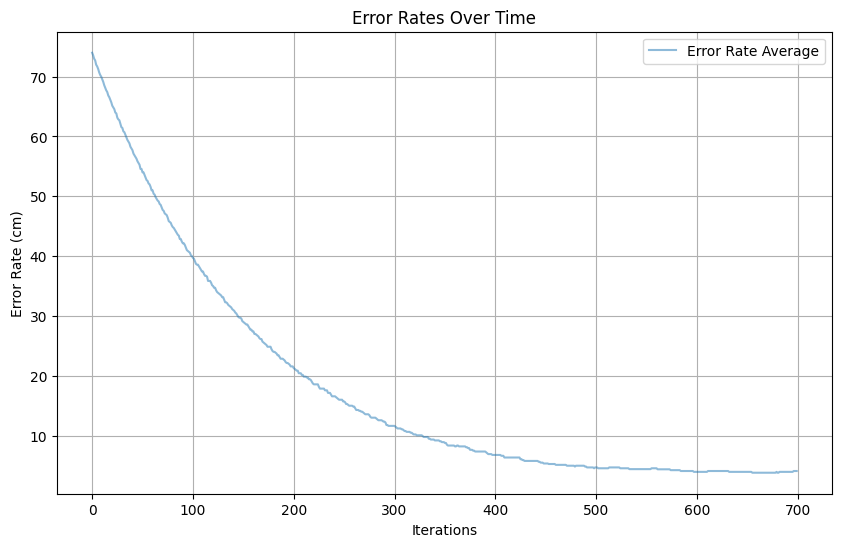

In [139]:
# Plotting the original and smoothed data
pyplot.figure(figsize=(10, 6))
pyplot.plot(errors, label='Error Rate Average', alpha=0.5)  # Slightly transparent
pyplot.title('Error Rates Over Time')
pyplot.xlabel('Iterations')
pyplot.ylabel('Error Rate (cm)')
pyplot.legend()
pyplot.grid(True)
pyplot.show()

In [ ]:
# Check the first image
path_to_image = dataset_dir + "20inches.jpg"
image = preprocess_image(path_to_image)


# Asserting that the image was read correctly 
assert image is not None, "ERROR: could not read image"

# Detecting the face in the image with the CVZone measurement 
face = detect_face_cvzone(image, CVZONE_DETECTOR_MAX_ONE, detect_multiple_faces=False)
assert len(face) == 468, "ERROR: could not detect the face in the image"

# Calculate the estimate depth 
depth = estimate_depth(face, focal_length)
print(f"[INFO] Estimated depth calculated is {depth} cm")


[INFO] Estimated depth calculated is 74 cm
